In [222]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

In [223]:
def get_data():
    path = "mnist.pkl.gz"
    
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
        
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def normalize(x, m, s):
    return (x-m) / s

In [224]:
x_train, y_train, x_valid, y_valid = get_data()
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [225]:
x_train = x_train.view(-1, 1, 28, 28)
x_valid = x_valid.view(-1, 1, 28, 28)

In [226]:
x_train.shape, x_valid.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [227]:
n, *_ = x_train.shape
c = y_train.max() + 1
nh = 32
n, c

(50000, tensor(10))

In [228]:
from torch import nn

In [229]:
l1 = nn.Conv2d(1, nh, 5)

In [230]:
x = x_valid[:100]

In [231]:
x.shape

torch.Size([100, 1, 28, 28])

In [232]:
def stats(x):
    return x.mean(), x.std()

In [233]:
stats(l1.weight), stats(l1.bias)

((tensor(0.0024, grad_fn=<MeanBackward0>),
  tensor(0.1160, grad_fn=<StdBackward0>)),
 (tensor(0.0058, grad_fn=<MeanBackward0>),
  tensor(0.1254, grad_fn=<StdBackward0>)))

In [234]:
t = l1(x)

In [235]:
stats(t)

(tensor(0.0113, grad_fn=<MeanBackward0>),
 tensor(0.6699, grad_fn=<StdBackward0>))

In [236]:
from torch.nn import init

init.kaiming_normal_(l1.weight, a=1.)
stats(l1(x))

(tensor(-0.0112, grad_fn=<MeanBackward0>),
 tensor(1.0991, grad_fn=<StdBackward0>))

In [237]:
import torch.nn.functional as F

In [238]:
def f1(x, a=0):
    return F.leaky_relu(l1(x), a)

In [239]:
init.kaiming_normal_(l1.weight, a=0)
stats(f1(x))

(tensor(0.5663, grad_fn=<MeanBackward0>),
 tensor(0.9656, grad_fn=<StdBackward0>))

In [240]:
l1 = nn.Conv2d(1, nh, 5)
stats(f1(x))

(tensor(0.2435, grad_fn=<MeanBackward0>),
 tensor(0.4603, grad_fn=<StdBackward0>))

In [241]:
l1.weight.shape, l1.bias.shape

(torch.Size([32, 1, 5, 5]), torch.Size([32]))

In [242]:
rec_fs = l1.weight[0,0].numel()
rec_fs

25

In [243]:
nf, ni, * _ = l1.weight.shape
nf, ni

(32, 1)

In [244]:
fan_in  =  ni * rec_fs
fan_out =  nf * rec_fs
fan_in, fan_out

(25, 800)

In [245]:
def gain(a):
    return math.sqrt(2.0 / (1 + a**2))

In [246]:
# Model

In [247]:
x_train, y_train, x_valid, y_valid = get_data()
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [248]:
n, m = x_train.shape
c = y_train.max() + 1
n, m, c

(50000, 784, tensor(10))

In [249]:
nh = 50

In [250]:
def mse(output, targ):
    return (output.squeeze(-1) - targ).pow(2).mean()

In [251]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
#         self.loss = mse
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
            
        return x

In [252]:
model = Model(m, nh, 10)

In [253]:
pred = model(x_train)

In [254]:
### Cross Entropy Loss

In [255]:
def log_softmax(x):
    return (x.exp()/(x.exp().sum(-1, keepdim = True))).log()

In [256]:
sm_pred = log_softmax(pred)

In [257]:
y_train.shape

torch.Size([50000])

In [258]:
def nll(input, targ):
    return -input[range(targ.shape[0]), targ].mean()

In [259]:
loss = nll(sm_pred, y_train)

In [260]:
loss

tensor(2.3592, grad_fn=<NegBackward0>)

In [261]:
# Simplify

def log_softmax(x):
    return x - x.exp().sum(-1, keepdim = True).log()

In [262]:
# LogSumExp for Numeric Stability

def logsumexp(x):
    m = x.max(-1)[0]
    return (m + (x-m[:, None]).exp().sum(-1, keepdim = True).log())

In [263]:
# Apply LogSumExp trick

def log_softmax(x):
    return x - x.logsumexp(-1, keepdim = True)

In [264]:
### Basic Training Loop

In [265]:
loss_func = F.cross_entropy

In [266]:
def accuracy(out, yb):
    return (torch.argmax(out, dim=1) == yb).float().mean()

In [267]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.1289,  0.4240,  0.4513, -0.2447, -0.1585,  0.1869, -0.2168, -0.0179,
         -0.3691, -0.3612], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [268]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3821, grad_fn=<NllLossBackward0>)

In [269]:
accuracy(preds, yb)

tensor(0.0469)

In [270]:
# Training Loop

In [271]:
lr = 0.5
epochs = 1

In [272]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, "weight"):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [273]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2944, grad_fn=<NllLossBackward0>), tensor(0.9375))

In [274]:
# Using Parameters and Optim

In [275]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [276]:
model = Model(m, nh, 10)

In [277]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [278]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i*bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            loss = loss_func(model(xb), yb)

            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    model.zero_grad()

In [279]:
fit()

In [280]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0247, grad_fn=<NllLossBackward0>), tensor(1.))

In [281]:
# Creating parameters function

In [282]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k, v)
            
    def __repr__(self):
        return f'{self._modules}'
    
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [283]:
md1 = DummyModule(m, nh, 10)

In [284]:
# Using PyTorch

In [285]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [286]:
model = Model(m, nh, 10)

In [287]:
for name, l in model.named_children():
    print(f"{name} : {l}")

l1 : Linear(in_features=784, out_features=50, bias=True)
l2 : Linear(in_features=50, out_features=10, bias=True)


In [288]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [289]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [290]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i*bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            loss = loss_func(model(xb), yb)

            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    model.zero_grad()

In [291]:
fit()

In [292]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0590, grad_fn=<NllLossBackward0>), tensor(1.))

In [293]:
# Creating Layers

In [294]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [295]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [296]:
model = Model(layers)

In [297]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [298]:
# Using nn.ModuleList and creating our own Sequential Class

In [299]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [300]:
model = SequentialModel(layers)

In [301]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [302]:
fit()

In [303]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0440, grad_fn=<NllLossBackward0>), tensor(1.))

In [304]:
# Using PyTorch's nn.Sequential

In [305]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [306]:
fit()

In [307]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0746, grad_fn=<NllLossBackward0>), tensor(1.))

In [308]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [309]:
### Optimizers 

In [310]:
class Optimizer():
    def __init__(self, params, lr = 0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [311]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [312]:
opt = Optimizer(model.parameters())

In [313]:
for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i*bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            loss = loss_func(model(xb), yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [314]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.3888, grad_fn=<NllLossBackward0>), tensor(0.8750))

In [315]:
# PyTorch's Optimizer

In [316]:
from torch import optim

In [317]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr = lr)

In [318]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2528, grad_fn=<NllLossBackward0>)

In [319]:
for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i*bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            loss = loss_func(model(xb), yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [320]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.4054, grad_fn=<NllLossBackward0>), tensor(0.8750))

In [321]:
# Dataset and DataLoader

In [322]:
# Dataset

In [323]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [324]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [325]:
model, opt = get_model()

In [326]:
for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            xb, yb = train_ds[i*bs : i*bs + bs]
        
            loss = loss_func(model(xb), yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [327]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.3149, grad_fn=<NllLossBackward0>), tensor(0.8750))

In [328]:
# DataLoader

In [329]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
        
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i + self.bs]

In [330]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [331]:
xb, yb = next(iter(valid_dl))

tensor(3)

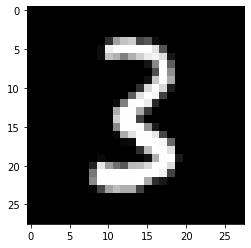

In [332]:
plt.imshow(xb[0].view(28,28), cmap='gray')
yb[0]

In [333]:
model, opt = get_model()

In [334]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [335]:
fit()

In [336]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.3273, grad_fn=<NllLossBackward0>), tensor(0.8750))

In [337]:
# Random Sampling

In [338]:
class Sampler():
    def __init__(self, ds, bs, shuffle = False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        
        for i in range(0, self.n, self.bs):
            yield self.idxs[i:i+self.bs]

In [339]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs),torch.stack(ys) 
    
class DataLoader():
    def __init__(self, ds, sampler, collate_fn = collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [340]:
train_samp = Sampler(train_ds, bs, shuffle = True)
valid_samp = Sampler(valid_ds, bs, shuffle = False)

In [341]:
train_dl = DataLoader(train_ds, sampler = train_samp, collate_fn = collate)
valid_dl = DataLoader(valid_ds, sampler = valid_samp, collate_fn = collate)

tensor(3)

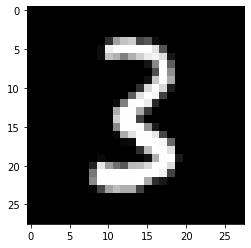

In [342]:
xb, yb = next(iter(valid_dl))

plt.imshow(xb[0].view(28,28), cmap='gray')
yb[0]

In [343]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.2395, grad_fn=<NllLossBackward0>), tensor(0.9219))

In [344]:
# PyTorch's DataLoader

In [345]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [346]:
train_dl = DataLoader(train_ds, bs, sampler = RandomSampler(train_ds), collate_fn = collate)
valid_dl = DataLoader(valid_ds, bs, sampler = SequentialSampler(train_ds), collate_fn = collate)

In [347]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.7059, grad_fn=<NllLossBackward0>), tensor(0.8438))

In [348]:
# PyTorch's Default

In [349]:
train_dl = DataLoader(train_ds, bs, shuffle = True, drop_last = True)
valid_dl = DataLoader(valid_ds, bs, shuffle = False)

In [350]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.2174, grad_fn=<NllLossBackward0>), tensor(0.9219))

In [351]:
# Validation

In [352]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0. , 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                loss = loss_func(pred, yb)
                tot_loss += loss
                tot_acc  +=  accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        
    return tot_loss/nv, tot_acc/nv

In [353]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return(DataLoader(train_ds, batch_size = bs, shuffle = True, **kwargs),
           DataLoader(valid_ds, batch_size = bs * 2, **kwargs))

In [354]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2097) tensor(0.9418)
1 tensor(0.4177) tensor(0.8896)
2 tensor(0.2112) tensor(0.9442)
3 tensor(0.2047) tensor(0.9472)
4 tensor(0.3823) tensor(0.9226)


In [355]:
# DataBunch/Learner

In [356]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [357]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c = None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
        
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.dataset

In [358]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [359]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr = lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [360]:
learn = Learner(*get_model(data), loss_func, data)

In [361]:
def fit(epochs, learn):
    for epoch in range(epochs):
        
        learn.model.train()
        for xb, yb in learn.data.train_dl:
            pred = learn.model(xb)
            loss = learn.loss_func(pred, yb)
            
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            
            
        learn.model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0. , 0.
            for xb, yb in learn.data.valid_dl:
                pred = learn.model(xb)
                loss = learn.loss_func(pred, yb)
                tot_loss += loss
                tot_acc  +=  accuracy(pred, yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        
    return tot_loss/nv, tot_acc/nv

In [362]:
loss, acc = fit(1, learn)

0 tensor(0.1958) tensor(0.9447)


In [363]:
## Adding Callbacks 

In [369]:
class Callback():
    
    def begin_fit(self, learn):
        self.learn = learn
        return True
    
    def after_fit(self):
        return True
    
    def begin_epoch(self, epoch):
        self.epoch = epoch
        return True
    
    def begin_validate(self):
        return True
    
    def after_epoch(self):
        return True
    
    def begin_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        return True
    
    def after_loss(self, loss):
        self.loss = loss
        return True
    
    def after_backward(self):
        return True
    
    def after_step(self):
        return True
    

In [374]:
class CallbackHandler():
    
    def __init__(self, cbs = None):
        self.cbs = cbs if cbs else []
        
    def begin_fit(self, learn):
        self.learn, self.in_train = learn, True
        learn.stop = False
        res = True
        for cb in self.cbs:
            res = res and cb.begin_fit(learn)
        
        return res
    
    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs:
            res = res and cb.after_fit()
        
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train = True
        res = True
        for cb in self.cbs:
            res = res and cb.begin_epoch(epoch)
        
        return res
    
    def begin_validate(self):
        self.learn.model.eval()
        self.in_train = False
        res = True
        for cb in self.cbs:
            res = res and cb.begin_validate()
        
        return res
    
    def after_epoch(self):
        res = True
        for cb in self.cbs:
            res = res and cb.after_epoch()
        
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs:
            res = res and cb.begin_batch(xb, yb)
        
        return res
    
    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs:
            res = res and cb.after_loss(loss)
        
        return res
    
    def after_backward(self):
        res = True
        for cb in self.cbs:
            res = res and cb.after_backward()
        
        return res
    
    def after_step(self):
        res = True
        for cb in self.cbs:
            res = res and cb.after_step()
        
        return res
    
    def do_stop(self):     
        try:
            return self.learn.stop
        finally:
            self.learn.stop = False

In [375]:
class TestCallback(Callback):
    def begin_fit(self, learn):
        super().begin_fit(learn)
        self.n_iters = 0
        return True
    
    def after_step(self):
        self.n_iters += 1
        print(self.n_iters)
        
        if(self.n_iters >= 10):
            self.learn.stop = True
            
        return True

In [376]:
# Refactoring fit and adding callbacks to it

def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb, yb):
        return
    
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    
    if not cb.after_loss(loss):
        return
    
    loss.backward()
    
    if(cb.after_backward()):
        cb.learn.opt.step()
        
    if(cb.after_step()):
        cb.learn.opt.zero_grad()

def all_batches(dl, cb):
   
    for xb,yb in dl:
        one_batch(xb, yb, cb)
        
        if(cb.do_stop()):
            return 
    
def fit(epochs, learn, cb):
    
    if not cb.begin_fit(learn):
        return
    
    for epoch in range(epochs):
        
        if not cb.begin_epoch(epoch):
            continue
        
        all_batches(learn.data.train_dl, cb)
        
        if (cb.begin_validate()):
            with torch.no_grad():
                all_batches(learn.data.valid_dl, cb)
            
        if(cb.do_stop() or not cb.after_epoch()):
            break
            
        cb.after_fit()
            
        

In [377]:
fit(1, learn, cb = CallbackHandler([TestCallback()]))

1
2
3
4
5
6
7
8
9
10


In [379]:
# Creating a Runner (Very Hazy)

In [385]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    
    def set_runner(self, run): 
        self.run=run
        
    def __getattr__(self, k): 
        return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
     

In [386]:
from typing import *

def listify(o):
    if o is None:
        return []
    
    if isinstance(o, list):
        return o
    
    if isinstance(o, str):
        return [o]
    
    if isinstance(o, Iterable):
        return list(o)
    
    return [o]

In [387]:
class Runner():
    def __init__(self, cbs = None, cb_funcs = None):
        cbs = listify(cbs)
        
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        
        self.stop, self.cbs = False, [TrainEvalCallback()] + cbs
        
    @property
    def opt(self):
        return self.learn.opt
    
    @property
    def model(self):
        return self.learn.model
    
    @property
    def loss_func(self):
        return self.learn.loss_func
    
    @property
    def data(self):
        return self.learn.data
    
    
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        
        if self('begin_batch'): 
            return
        
        self.pred = self.model(self.xb)
        
        if self('after_pred'): 
            return
        
        self.loss = self.loss_func(self.pred, self.yb)
        
        if self('after_loss') or not self.in_train: 
            return
        
        self.loss.backward()
        
        if self('after_backward'):
            return
        
        self.opt.step()
        
        if self('after_step'): 
            return
        
        self.opt.zero_grad()

    
    
    def all_batches(self, dl):
        self.iters = len(dl)
        
        for xb,yb in dl:
            if self.stop: 
                break
                
            self.one_batch(xb, yb)
            self('after_batch')
            
        self.stop = False
        
        
    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: 
                cb.set_runner(self)
                
            if self('begin_fit'): 
                return
            
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): 
                    self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): 
                        self.all_batches(self.data.valid_dl)
                        
                if self('after_epoch'):
                    break
            
        finally:
            self('after_fit')
            self.learn = None

            
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): 
                return True
            
        return False

In [388]:
class TrainEvalCallback(Callback):
    
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: 
            return
        
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [390]:
class TestCallback(Callback):
    
    def after_step(self):
        if self.train_eval.n_iters>=10: 
            return True

In [391]:
# Why self.train_eval.n_iters??

In [392]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [393]:
TrainEvalCallback().name

'train_eval'

In [395]:
class AvgStats():
    def __init__(self, metrics, in_train): 
        self.metrics, self.in_train = listify(metrics), in_train
    
    def reset(self):
        self.tot_loss, self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): 
        return [self.tot_loss.item()] + self.tot_mets
    
    @property
    def avg_stats(self): 
        return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: 
            return ""
        
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        
        with torch.no_grad(): 
            stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [396]:
learn = Learner(*get_model(data), loss_func, data)

In [397]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [398]:
run.fit(2, learn)

train: [0.3228669921875, tensor(0.9012)]
valid: [0.17170430908203124, tensor(0.9488)]
train: [0.14759888671875, tensor(0.9550)]
valid: [0.11999556884765625, tensor(0.9671)]


In [399]:
loss, acc = stats.valid_stats.avg_stats
loss, acc

(0.11999556884765625, tensor(0.9671))

In [400]:
from functools import partial

In [401]:
acc_cbf = partial(AvgStatsCallback,accuracy)

In [402]:
run = Runner(cb_funcs=acc_cbf)

In [403]:
run.fit(1, learn)

train: [0.111993837890625, tensor(0.9647)]
valid: [0.15203140869140624, tensor(0.9551)]


In [404]:
run.avg_stats.valid_stats.avg_stats

[0.15203140869140624, tensor(0.9551)]